In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_columns = 50

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
def preprocess_df(file_path):

    file_path = 'data.csv'
    df = pd.read_csv(file_path)
    df = df.drop_duplicates()

    columns_to_exclude_max = ['sight_left', 'sight_right', 'SGOT_AST', 'gamma_GTP']
    for column in columns_to_exclude_max:
        df = df[df[column] != df[column].max()]

    sus_columns = ['waistline', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'serum_creatinine', 'SGOT_AST',
                   'SGOT_ALT', 'gamma_GTP', 'hemoglobin']

    # Initialize a mask to select all rows initially
    mask = pd.Series([True] * df.shape[0])

    for column in sus_columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define the bounds for the outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Update the mask to identify rows that are not outliers in the current column
        mask = mask & (df[column] >= lower_bound) & (df[column] <= upper_bound)

    # Apply the mask to filter out the outliers
    df = df[mask]

    df['BMI'] = df['weight'] / ((df['height'] / 100) ** 2)
    df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, float('inf')], labels=['0', '1', '2', '3'])
    df['MAP'] = df['DBP'] + (df['SBP'] - df['DBP']) / 3
    df['Liver_Enzyme_Ratio'] = df['SGOT_AST'] / df['SGOT_ALT']
    df['Anemia_Indicator'] = (df['hemoglobin'] < 12).astype(int)

    smoker_type_mapping = {1.0: 'Non-Smoker', 2.0: 'Former Smoker', 3.0: 'Current Smoker'}
    df['Smoker Type'] = df['SMK_stat_type_cd'].map(smoker_type_mapping)
    
    label_encoder = LabelEncoder()
    categorical_columns = ['sex','DRK_YN']  #1:male, 1:Y

    # Apply label encoding to each categorical column

    for column in categorical_columns:
        df[column] = label_encoder.fit_transform(df[column])
    columns_to_convert = ['sex','DRK_YN', 'SMK_stat_type_cd', 'urine_protein', 'hear_left', 'hear_right', 'Anemia_Indicator']
    df[columns_to_convert] = df[columns_to_convert].astype('int')
    df[columns_to_convert] = df[columns_to_convert].astype('category')

    return df

def encode_and_scale(df):

    df['prev_smoker'] = np.where(df['SMK_stat_type_cd'] == 2, 1, 0) #1 for previous smoker
    df['prev_smoker'] = df['prev_smoker'].astype('category')
    cols_to_drop = ["Smoker Type",
                         "BMI_Category",
                         "DRK_YN"
                         ]
    df.drop(columns=cols_to_drop, inplace=True)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    columns_to_convert = df.select_dtypes(include=['category']).columns
    df[columns_to_convert] = df[columns_to_convert].astype('int')

    return df

def get_data(filepath):
    return encode_and_scale(preprocess_df(filepath))

def split_train_test(df, y, test_size = 0.2):

    X = df.drop(columns=["prev_smoker", "SMK_stat_type_cd"])
    y = df[y]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test

# Downsample

In [10]:
df = get_data('data.csv')
X_train, X_test, y_train, y_test = split_train_test(df, y = 'prev_smoker', test_size=0.2)

In [11]:
train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data.prev_smoker == 0]
minority_class = train_data[train_data.prev_smoker == 1]

# Downsample majority class
majority_downsampled = majority_class.sample(n=len(minority_class), random_state=42)

# Combine minority class with downsampled majority class
downsampled_data = pd.concat([majority_downsampled, minority_class])

# Splitting back into X_train and y_train
X_train = downsampled_data.drop('prev_smoker', axis=1)
y_train = downsampled_data['prev_smoker']

# Baseline Logistic

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print('accuracy')
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

accuracy
0.6673059411131653
              precision    recall  f1-score   support

           0       0.98      0.62      0.76    121723
           1       0.32      0.92      0.47     23233

    accuracy                           0.67    144956
   macro avg       0.65      0.77      0.61    144956
weighted avg       0.87      0.67      0.71    144956



In [15]:
y_train.value_counts()

prev_smoker
0    92088
1    92088
Name: count, dtype: int64

In [16]:
feature_names = X_train.columns
coefficients = model.coef_.flatten()

coef_summary = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
print(coef_summary)

               Feature  Coefficient
0                  sex     2.783619
1                  age     0.364023
2               height     0.367268
3               weight    -0.260923
4            waistline     0.029012
5           sight_left     0.033265
6          sight_right     0.023813
7            hear_left    -0.048487
8           hear_right    -0.120055
9                  SBP    -0.088340
10                 DBP     0.061956
11                BLDS     0.049855
12           tot_chole    -0.385536
13           HDL_chole     0.281108
14           LDL_chole     0.348911
15        triglyceride     0.130090
16          hemoglobin    -0.150023
17       urine_protein     0.021629
18    serum_creatinine     0.025691
19            SGOT_AST     0.025390
20            SGOT_ALT     0.010535
21           gamma_GTP     0.017220
22                 BMI     0.316709
23                 MAP    -0.002019
24  Liver_Enzyme_Ratio     0.002150
25    Anemia_Indicator    -0.351328


AUC Score: 0.8168727704324974
Optimal Threshold: 0.5607452622525003


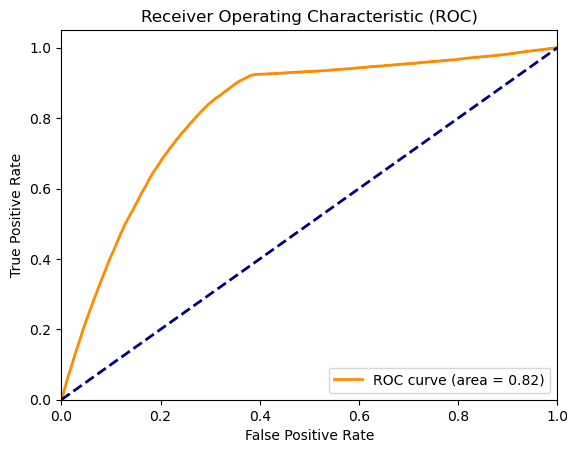

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Get probabilities for the positive class
y_probs = model.predict_proba(X_test)[:, 1]
# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc_score}")
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [18]:
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

print('accuracy')
print(accuracy_score(y_test, y_pred_optimal))
print(classification_report(y_test, y_pred_optimal))

accuracy
0.6872706200502221
              precision    recall  f1-score   support

           0       0.97      0.65      0.78    121723
           1       0.33      0.90      0.48     23233

    accuracy                           0.69    144956
   macro avg       0.65      0.77      0.63    144956
weighted avg       0.87      0.69      0.73    144956



Accuracy: There's a decrease in overall accuracy to 68.73% from 70.24% before implementing downsampling.

Precision (Class 1): The precision for Class 1 remains at 0.33, similar to the performance before downsampling. This metric indicates the proportion of correct predictions out of all predictions made for Class 1 and suggests no change in the model's ability to accurately identify positive cases as such.

Recall (Class 1): The recall for Class 1 remains high at 0.90, indicating that the model is very good at identifying the majority of actual Class 1 instances. 

# Random Forest

Do cross validation on a simple tree model to find the optimal tree size for random forest.

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

dt_model = DecisionTreeClassifier(max_depth=15, random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6992880598250504

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.67      0.79    121723
           1       0.33      0.83      0.47     23233

    accuracy                           0.70    144956
   macro avg       0.64      0.75      0.63    144956
weighted avg       0.85      0.70      0.74    144956



In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(n_estimators=500, max_depth = 20, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7052277932614035

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.67      0.79    121723
           1       0.34      0.88      0.49     23233

    accuracy                           0.71    144956
   macro avg       0.65      0.78      0.64    144956
weighted avg       0.87      0.71      0.74    144956



## Find optimal decision threshold

**Method 1: Maximizing the Difference Between TPR and FPR**

In [31]:
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]

AUC Score: 0.8322069823503604
Optimal Threshold: 0.5081867941751536


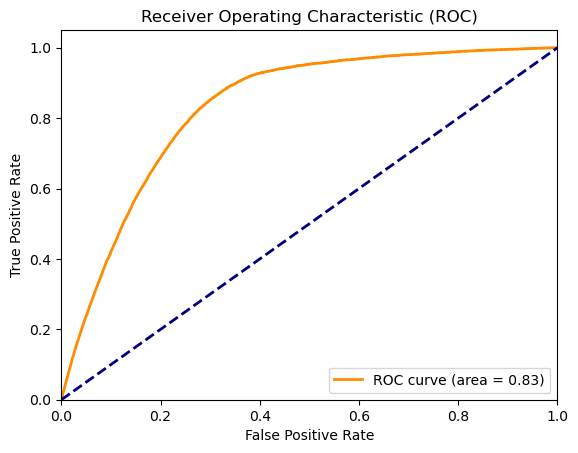

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs_rf)
auc_score = roc_auc_score(y_test, y_probs_rf)
print(f"AUC Score: {auc_score}")
# Calculate ROC curve
roc_auc = auc(fpr, tpr)
# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Maximizing the Geometric Mean (G-Mean) of Sensitivity and Specificity**

The G-Mean provides a balance between sensitivity and specificity, treating both equally. It is particularly useful when you're dealing with imbalanced classes or when both false positives and false negatives are costly. The geometric mean helps ensure that neither sensitivity nor specificity is disproportionately low.

In [33]:
# Calculate the G-mean for each threshold, which balances sensitivity and specificity
gmeans = np.sqrt(tpr * (1-fpr))

# Locate the index of the largest G-mean
ix = np.argmax(gmeans)
optimal_threshold = thresholds[ix]
print('Best Threshold=%f' % (optimal_threshold))

Best Threshold=0.553302


In [34]:
y_pred_optimal = (y_probs_rf >= 0.55).astype(int)

print('accuracy')
print(accuracy_score(y_test, y_pred_optimal))
print(classification_report(y_test, y_pred_optimal))

accuracy
0.7248889318137918
              precision    recall  f1-score   support

           0       0.96      0.70      0.81    121723
           1       0.35      0.85      0.50     23233

    accuracy                           0.72    144956
   macro avg       0.66      0.78      0.65    144956
weighted avg       0.86      0.72      0.76    144956



In [35]:
feature_importances = rf_model.feature_importances_
features_and_importances = zip(feature_names, feature_importances)

# Sorting the features by importance
sorted_features_and_importances = sorted(features_and_importances, key=lambda x: x[1], reverse=True)

# Printing the sorted features and their importances
for feature, importance in sorted_features_and_importances:
    print(f"{feature}: {importance}")

sex: 0.2280132387311814
height: 0.08343128505630099
hemoglobin: 0.07677467598583604
age: 0.05514444749063988
serum_creatinine: 0.04616730458150749
waistline: 0.044797666127276384
weight: 0.04083610360839978
gamma_GTP: 0.03782353552981852
triglyceride: 0.0336721551244721
Liver_Enzyme_Ratio: 0.03217773001539939
tot_chole: 0.03149988559771516
HDL_chole: 0.031338399123076316
LDL_chole: 0.03120762782876203
BLDS: 0.029912936013469477
MAP: 0.0282228566797137
SGOT_ALT: 0.02756607223975123
SBP: 0.026473751604841552
SGOT_AST: 0.025103811181307313
BMI: 0.024426916824508413
DBP: 0.023508407675566067
sight_left: 0.017375115765007595
sight_right: 0.01732041389921768
urine_protein: 0.003018407103828822
Anemia_Indicator: 0.0017885879092225335
hear_left: 0.0012319937717931435
hear_right: 0.001166674531387084


# Comparison Logistic vs Random Forest (Adjusted threshold)

**Random Forest (Downsampling Adjusted)**

Accuracy: 68.73% 

Precision (Class 1): 0.33

Recall (Class 1): 0.90

F1-Score (Class 1): 0.48

Macro Avg F1-Score: 0.63

Weighted Avg F1-Score: 0.73

**Logistic Regression (Downsampling Adjusted)**

Accuracy: 72.49%

Precision (Class 1): 0.35

Recall (Class 1): 0.85

F1-Score (Class 1): 0.50

Macro Avg F1-Score: 0.65

Weighted Avg F1-Score: 0.76


**Accuracy**: The Random Forest model shows a notable improvement in accuracy over the Logistic Regression model (72.49% vs. 68.73%).

**Precision and Recall for Class 1**: Both models see an improvement in precision for Class 1 with downsampling, with Random Forest slightly outperforming Logistic Regression (0.35 vs. 0.33). Logistic Regression has a higher recall for Class 1 compared to Random Forest (0.90 vs. 0.85), indicating that Logistic Regression is better at identifying the positive Class 1 instances. 

In [36]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)
# Predicting the Test set results
y_pred = xgb_clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy")
print(accuracy)

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy
0.7136855321614834
              precision    recall  f1-score   support

           0       0.96      0.68      0.80    121723
           1       0.34      0.87      0.49     23233

    accuracy                           0.71    144956
   macro avg       0.65      0.78      0.65    144956
weighted avg       0.86      0.71      0.75    144956



In [37]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Convert the dataset into an optimized data structure called DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define initial best params and MAE
params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': .3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'binary:logistic',
}

# Define the range of hyperparameters to tune
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3, 10)
    for min_child_weight in range(1, 6)
]

min_logloss = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=100,
        seed=42,
        nfold=5,
        metrics={'logloss'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (max_depth, min_child_weight)

print("Best params: {}, {}, LogLoss: {}".format(best_params[0], best_params[1], min_logloss))

CV with max_depth=3, min_child_weight=1
	LogLoss 0.48936389731586616 for 57 rounds
CV with max_depth=3, min_child_weight=2
	LogLoss 0.48934028849649225 for 57 rounds
CV with max_depth=3, min_child_weight=3
	LogLoss 0.4893026945061062 for 69 rounds
CV with max_depth=3, min_child_weight=4
	LogLoss 0.4893589327815926 for 59 rounds
CV with max_depth=3, min_child_weight=5
	LogLoss 0.4893300057277926 for 57 rounds
CV with max_depth=4, min_child_weight=1
	LogLoss 0.48901479143342785 for 25 rounds
CV with max_depth=4, min_child_weight=2
	LogLoss 0.48909772238663046 for 28 rounds
CV with max_depth=4, min_child_weight=3
	LogLoss 0.4890277240385205 for 36 rounds
CV with max_depth=4, min_child_weight=4
	LogLoss 0.48906050875347373 for 27 rounds
CV with max_depth=4, min_child_weight=5
	LogLoss 0.48898533007484984 for 26 rounds
CV with max_depth=5, min_child_weight=1
	LogLoss 0.4891073569731179 for 19 rounds
CV with max_depth=5, min_child_weight=2
	LogLoss 0.4890400294012637 for 19 rounds
CV with ma

In [38]:
best_params = {
    'max_depth': 5,
    'min_child_weight': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False
}
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
num_boost_round = 1000  # Starting with a large number and using early stopping
early_stopping_rounds = 50  # Stop if no improvement after this many rounds

model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],  # Optional: Include a test set for early stopping
    early_stopping_rounds=early_stopping_rounds
)

print("Best model trained with logloss:", model.best_score)

[0]	Test-logloss:0.60483
[1]	Test-logloss:0.56149
[2]	Test-logloss:0.53822
[3]	Test-logloss:0.52494
[4]	Test-logloss:0.51722
[5]	Test-logloss:0.51246
[6]	Test-logloss:0.50968
[7]	Test-logloss:0.50767
[8]	Test-logloss:0.50640
[9]	Test-logloss:0.50551
[10]	Test-logloss:0.50487
[11]	Test-logloss:0.50439
[12]	Test-logloss:0.50402
[13]	Test-logloss:0.50378
[14]	Test-logloss:0.50363
[15]	Test-logloss:0.50346
[16]	Test-logloss:0.50331
[17]	Test-logloss:0.50320
[18]	Test-logloss:0.50314
[19]	Test-logloss:0.50306
[20]	Test-logloss:0.50298
[21]	Test-logloss:0.50295
[22]	Test-logloss:0.50295
[23]	Test-logloss:0.50295
[24]	Test-logloss:0.50292
[25]	Test-logloss:0.50294
[26]	Test-logloss:0.50300
[27]	Test-logloss:0.50305
[28]	Test-logloss:0.50306
[29]	Test-logloss:0.50311
[30]	Test-logloss:0.50311
[31]	Test-logloss:0.50319
[32]	Test-logloss:0.50323
[33]	Test-logloss:0.50325
[34]	Test-logloss:0.50326
[35]	Test-logloss:0.50329
[36]	Test-logloss:0.50332
[37]	Test-logloss:0.50331
[38]	Test-logloss:0.50

In [39]:
y_probs_xgb = model.predict(dtest)

AUC Score: 0.8328270060121868
Optimal Threshold: 0.4669676125049591


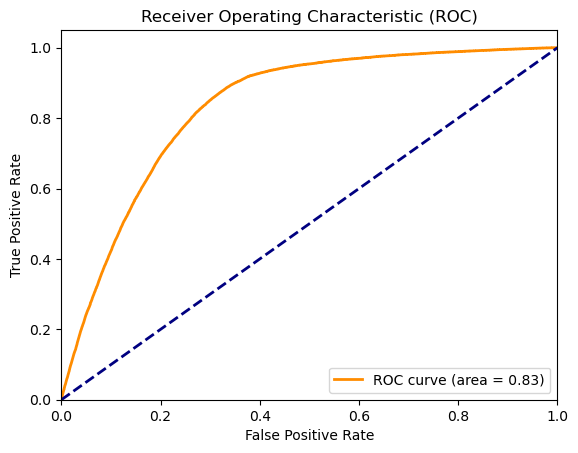

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs_xgb)
auc_score = roc_auc_score(y_test, y_probs_xgb)
print(f"AUC Score: {auc_score}")
# Calculate ROC curve
roc_auc = auc(fpr, tpr)
# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [41]:
# Calculate the G-mean for each threshold, which balances sensitivity and specificity
gmeans = np.sqrt(tpr * (1-fpr))

# Locate the index of the largest G-mean
ix = np.argmax(gmeans)
optimal_threshold = thresholds[ix]
print('Best Threshold=%f' % (optimal_threshold))

Best Threshold=0.544055


In [44]:
y_pred_optimal = (y_probs_xgb >= 0.55).astype(int)

print('accuracy')
print(accuracy_score(y_test, y_pred_optimal))
print(classification_report(y_test, y_pred_optimal))

accuracy
0.7287521730732084
              precision    recall  f1-score   support

           0       0.96      0.71      0.81    121723
           1       0.35      0.84      0.50     23233

    accuracy                           0.73    144956
   macro avg       0.66      0.77      0.66    144956
weighted avg       0.86      0.73      0.76    144956



In [45]:
logistic_regression_metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': 0.6873,
    'Precision (Class 1)': 0.33,
    'Recall (Class 1)': 0.90,
    'F1-Score (Class 1)': 0.48,
    'macro f1': 0.63,
    'weighted f1': 0.73 
}

random_forest_metrics = {
    'Model': 'Random Forest',
    'Accuracy': 0.7249,
    'Precision (Class 1)': 0.35,
    'Recall (Class 1)': 0.85,
    'F1-Score (Class 1)': 0.50,
    'macro f1': 0.65,
    'weighted f1': 0.76
}

xgboost_metrics = {
    'Model': 'XGBoost',
    'Accuracy': 0.7288,
    'Precision (Class 1)': 0.35,
    'Recall (Class 1)': 0.84,
    'F1-Score (Class 1)': 0.50,
    'macro f1': 0.66,
    'weighted f1': 0.76
}

# Creating a DataFrame
results_df = pd.DataFrame([logistic_regression_metrics, random_forest_metrics, xgboost_metrics])

# Displaying the DataFrame for comparison
results_df

,Model,Accuracy,Precision (Class 1),Recall (Class 1),F1-Score (Class 1),macro f1,weighted f1
0,Logistic Regression,0.6873,0.33,0.90,0.48,0.63,0.73
1,Random Forest,0.7249,0.35,0.85,0.50,0.65,0.76
2,XGBoost,0.7288,0.35,0.84,0.50,0.66,0.76


XGBoost has the highest overall accuracy (72.88%), closely followed by Random Forest (72.49%), and Logistic Regression trails at 68.73%. 

All three models have a similar precision for Class 1 (0.35 for both Random Forest and XGBoost, and 0.33 for Logistic Regression). This indicates that the proportion of correct positive predictions out of all positive predictions made for Class 1 is slightly better in ensemble models (Random Forest and XGBoost) than in Logistic Regression.

Logistic Regression exhibits the highest recall for Class 1 at 0.90, indicating its superior capability to identify most of the actual Class 1 instances. Random Forest and XGBoost have slightly lower recall values (0.85 and 0.84, respectively), suggesting they miss more true positives than the Logistic Regression model.

XGBoost slightly outperforms Random Forest in terms of accuracy and balanced performance across classes as reflected in macro and weighted F1 scores. It strikes a good balance between handling the minority class well (high F1-score for Class 1) while also achieving the highest overall accuracy.

Random Forest shows strong performance, closely trailing XGBoost and outperforming Logistic Regression in all metrics except for recall for Class 1.
Logistic Regression, while having the lowest accuracy and balanced performance metrics, excels in recall for Class 1, making it a potentially preferable model in scenarios where missing out on Class 1 instances carries a high cost (e.g., in medical diagnoses where false negatives are more detrimental than false positives).